In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test


from keras.models import Model
from keras.layers import *
from keras.initializers import *
from keras.layers.merge import concatenate

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def highway_conv_1d(inputLayer, filtersNumber, dropout = 0.2, keepInitialBias = -1):
    highwayInput = Input(shape=(400, 300))
    convolution = one_by_one(filtersNumber, highwayInput, dropout)
    
    keep = Conv1D(
        filtersNumber, 1, 
        activation = 'sigmoid',
        padding = 'same', 
        kernel_initializer = 'he_uniform',
        bias_initializer = Constant(keepInitialBias)
    )(highwayInput)
    
    keep = BatchNormalization()(keep)
    forget = Lambda(lambda layer: 1 - layer)(keep)
    
    gate = add(
        [
            multiply([keep, convolution]),
            multiply([forget, highwayInput])
        ]
    )
    
    return Model(inputs=[highwayInput], outputs = [gate])(inputLayer)

In [0]:
def highway_block(inputLayer, filtersNumber, convolutions = 3):
    block = inputLayer
    for i in range(convolutions):
       block = highway_conv_1d(block, filtersNumber)
    return block

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

highway = highway_block(embedding_dropout, 300, 3)

features = yoon_kim_feature_extractor(filtersNumber, highway)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21376/102124 [=====>........................] - ETA: 8:19 - loss: 0.2160 - acc: 0.9229

 91712/102124 [=========================>....] - ETA: 1:02 - loss: 0.1079 - acc: 0.9624

102124/102124 [==============================] - 661s 6ms/step - loss: 0.1034 - acc: 0.9640 - val_loss: 0.0604 - val_acc: 0.9798
Epoch 2/32
 10048/102124 [=>............................] - ETA: 9:08 - loss: 0.0664 - acc: 0.9769

 52384/102124 [==============>...............] - ETA: 4:56 - loss: 0.0651 - acc: 0.9768

 88992/102124 [=========================>....] - ETA: 1:18 - loss: 0.0636 - acc: 0.9773

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0633 - acc: 0.9774 - val_loss: 0.0528 - val_acc: 0.9803
roc-auc: 0.9711 - roc-auc_val: 0.9692                                                                                                    
Epoch 3/32
  5632/102124 [>.............................] - ETA: 9:35 - loss: 0.0609 - acc: 0.9780

 42400/102124 [===========>..................] - ETA: 5:56 - loss: 0.0612 - acc: 0.9779

102112/102124 [============================>.] - ETA: 0s - loss: 0.0595 - acc: 0.9784

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0595 - acc: 0.9784 - val_loss: 0.0544 - val_acc: 0.9791
Epoch 4/32
 13984/102124 [===>..........................] - ETA: 8:45 - loss: 0.0566 - acc: 0.9794

 64448/102124 [=================>............] - ETA: 3:44 - loss: 0.0566 - acc: 0.9793

101440/102124 [============================>.] - ETA: 4s - loss: 0.0561 - acc: 0.9794

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0561 - acc: 0.9793 - val_loss: 0.0503 - val_acc: 0.9813
roc-auc: 0.9802 - roc-auc_val: 0.9777                                                                                                    
Epoch 5/32
  8544/102124 [=>............................] - ETA: 9:17 - loss: 0.0529 - acc: 0.9804

 56896/102124 [===============>..............] - ETA: 4:29 - loss: 0.0535 - acc: 0.9803

102112/102124 [============================>.] - ETA: 0s - loss: 0.0535 - acc: 0.9802

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0535 - acc: 0.9802 - val_loss: 0.0491 - val_acc: 0.9814
Epoch 6/32
 14016/102124 [===>..........................] - ETA: 8:45 - loss: 0.0525 - acc: 0.9803

 92992/102124 [==========================>...] - ETA: 54s - loss: 0.0524 - acc: 0.9805

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0521 - acc: 0.9806 - val_loss: 0.0465 - val_acc: 0.9821
roc-auc: 0.9829 - roc-auc_val: 0.9811                                                                                                    
Epoch 7/32
  6592/102124 [>.............................] - ETA: 9:30 - loss: 0.0512 - acc: 0.9814

 52768/102124 [==============>...............] - ETA: 4:54 - loss: 0.0507 - acc: 0.9812

 97120/102124 [===========================>..] - ETA: 29s - loss: 0.0510 - acc: 0.9810

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0508 - acc: 0.9810 - val_loss: 0.0456 - val_acc: 0.9825
Epoch 8/32
 12096/102124 [==>...........................] - ETA: 8:56 - loss: 0.0499 - acc: 0.9819

 99040/102124 [============================>.] - ETA: 18s - loss: 0.0494 - acc: 0.9815

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0495 - acc: 0.9814 - val_loss: 0.0464 - val_acc: 0.9823
roc-auc: 0.9832 - roc-auc_val: 0.9817                                                                                                    
Epoch 9/32
  8000/102124 [=>............................] - ETA: 9:20 - loss: 0.0477 - acc: 0.9824

 71232/102124 [===================>..........] - ETA: 3:04 - loss: 0.0490 - acc: 0.9815

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0488 - acc: 0.9816 - val_loss: 0.0457 - val_acc: 0.9827

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00021763764380011708.
Epoch 10/32
  1632/102124 [..............................] - ETA: 9:59 - loss: 0.0517 - acc: 0.9838

 94144/102124 [==========================>...] - ETA: 47s - loss: 0.0482 - acc: 0.9818

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0483 - acc: 0.9817 - val_loss: 0.0488 - val_acc: 0.9821
roc-auc: 0.9848 - roc-auc_val: 0.9828                                                                                                    
Epoch 11/32
  6784/102124 [>.............................] - ETA: 9:28 - loss: 0.0500 - acc: 0.9815

 47552/102124 [============>.................] - ETA: 5:25 - loss: 0.0469 - acc: 0.9825

 96608/102124 [===========================>..] - ETA: 32s - loss: 0.0474 - acc: 0.9821

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0475 - acc: 0.9820 - val_loss: 0.0452 - val_acc: 0.9828
Epoch 12/32
 11776/102124 [==>...........................] - ETA: 8:59 - loss: 0.0458 - acc: 0.9827

 72128/102124 [====================>.........] - ETA: 2:58 - loss: 0.0469 - acc: 0.9822

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0470 - acc: 0.9822 - val_loss: 0.0465 - val_acc: 0.9821
roc-auc: 0.9871 - roc-auc_val: 0.9843                                                                                                    
Epoch 13/32
  1600/102124 [..............................] - ETA: 9:59 - loss: 0.0451 - acc: 0.9836

 41984/102124 [===========>..................] - ETA: 5:58 - loss: 0.0464 - acc: 0.9825

 90976/102124 [=========================>....] - ETA: 1:06 - loss: 0.0463 - acc: 0.9824

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0462 - acc: 0.9824 - val_loss: 0.0447 - val_acc: 0.9830
Epoch 14/32
  9760/102124 [=>............................] - ETA: 9:11 - loss: 0.0477 - acc: 0.9817

 46464/102124 [============>.................] - ETA: 5:31 - loss: 0.0463 - acc: 0.9822

 94272/102124 [==========================>...] - ETA: 46s - loss: 0.0456 - acc: 0.9825

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0456 - acc: 0.9825 - val_loss: 0.0478 - val_acc: 0.9827
roc-auc: 0.9876 - roc-auc_val: 0.9848                                                                                                    
Epoch 15/32
  6816/102124 [=>............................] - ETA: 9:29 - loss: 0.0459 - acc: 0.9826

 46176/102124 [============>.................] - ETA: 5:33 - loss: 0.0458 - acc: 0.9826

 88608/102124 [=========================>....] - ETA: 1:20 - loss: 0.0452 - acc: 0.9828

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0455 - acc: 0.9827 - val_loss: 0.0548 - val_acc: 0.9822
Epoch 16/32
  8896/102124 [=>............................] - ETA: 9:16 - loss: 0.0451 - acc: 0.9823

 56288/102124 [===============>..............] - ETA: 4:33 - loss: 0.0451 - acc: 0.9825

102112/102124 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9826

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0449 - acc: 0.9826 - val_loss: 0.0472 - val_acc: 0.9831
roc-auc: 0.9882 - roc-auc_val: 0.9854                                                                                                    
Epoch 17/32
  8704/102124 [=>............................] - ETA: 9:17 - loss: 0.0440 - acc: 0.9831

 57312/102124 [===============>..............] - ETA: 4:27 - loss: 0.0451 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9828

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0448 - acc: 0.9828 - val_loss: 0.0525 - val_acc: 0.9823
Epoch 18/32
 13984/102124 [===>..........................] - ETA: 8:45 - loss: 0.0458 - acc: 0.9817

 60672/102124 [================>.............] - ETA: 4:07 - loss: 0.0449 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0445 - acc: 0.9829

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0445 - acc: 0.9829 - val_loss: 0.0451 - val_acc: 0.9830
roc-auc: 0.9889 - roc-auc_val: 0.986                                                                                                    
Epoch 19/32
  8736/102124 [=>............................] - ETA: 9:17 - loss: 0.0438 - acc: 0.9832

 82816/102124 [=======================>......] - ETA: 1:55 - loss: 0.0438 - acc: 0.9831

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0440 - acc: 0.9831 - val_loss: 0.0450 - val_acc: 0.9832
Epoch 20/32
  6592/102124 [>.............................] - ETA: 9:29 - loss: 0.0475 - acc: 0.9816

 51360/102124 [==============>...............] - ETA: 5:03 - loss: 0.0440 - acc: 0.9828

102112/102124 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9831

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0435 - acc: 0.9831 - val_loss: 0.0457 - val_acc: 0.9832

Epoch 00020: ReduceLROnPlateau reducing learning rate to 6.934809061931446e-05.
roc-auc: 0.9889 - roc-auc_val: 0.9854                                                                                                    
Epoch 21/32
  5952/102124 [>.............................] - ETA: 9:34 - loss: 0.0412 - acc: 0.9835

 76000/102124 [=====================>........] - ETA: 2:35 - loss: 0.0432 - acc: 0.9832

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0433 - acc: 0.9832 - val_loss: 0.0497 - val_acc: 0.9828
Epoch 22/32
  4032/102124 [>.............................] - ETA: 9:45 - loss: 0.0454 - acc: 0.9820

 42848/102124 [===========>..................] - ETA: 5:53 - loss: 0.0431 - acc: 0.9833

 97696/102124 [===========================>..] - ETA: 26s - loss: 0.0434 - acc: 0.9831

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0434 - acc: 0.9831 - val_loss: 0.0458 - val_acc: 0.9830
roc-auc: 0.9892 - roc-auc_val: 0.9858                                                                                                    
Epoch 23/32
  7680/102124 [=>............................] - ETA: 9:23 - loss: 0.0442 - acc: 0.9827

 44864/102124 [============>.................] - ETA: 5:41 - loss: 0.0437 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0430 - acc: 0.9831

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0430 - acc: 0.9831 - val_loss: 0.0442 - val_acc: 0.9834
Epoch 24/32
 13952/102124 [===>..........................] - ETA: 8:46 - loss: 0.0418 - acc: 0.9834

 54144/102124 [==============>...............] - ETA: 4:46 - loss: 0.0419 - acc: 0.9835

 90816/102124 [=========================>....] - ETA: 1:07 - loss: 0.0427 - acc: 0.9833

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0424 - acc: 0.9834 - val_loss: 0.0501 - val_acc: 0.9826
roc-auc: 0.9886 - roc-auc_val: 0.9851                                                                                                    
Epoch 25/32
  6048/102124 [>.............................] - ETA: 9:33 - loss: 0.0415 - acc: 0.9842

 43232/102124 [===========>..................] - ETA: 5:51 - loss: 0.0424 - acc: 0.9835

 81088/102124 [======================>.......] - ETA: 2:05 - loss: 0.0426 - acc: 0.9835

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0426 - acc: 0.9834 - val_loss: 0.0468 - val_acc: 0.9830
Epoch 26/32
  5984/102124 [>.............................] - ETA: 9:33 - loss: 0.0439 - acc: 0.9836

 69824/102124 [===================>..........] - ETA: 3:12 - loss: 0.0425 - acc: 0.9835

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0425 - acc: 0.9835 - val_loss: 0.0528 - val_acc: 0.9822
roc-auc: 0.9888 - roc-auc_val: 0.985                                                                                                    
Epoch 27/32
  1056/102124 [..............................] - ETA: 10:06 - loss: 0.0384 - acc: 0.9853

 70944/102124 [===================>..........] - ETA: 3:06 - loss: 0.0424 - acc: 0.9837

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0423 - acc: 0.9836 - val_loss: 0.0490 - val_acc: 0.9829
Epoch 28/32
  2048/102124 [..............................] - ETA: 9:57 - loss: 0.0427 - acc: 0.9819

 39520/102124 [==========>...................] - ETA: 6:13 - loss: 0.0420 - acc: 0.9836

 79808/102124 [======================>.......] - ETA: 2:13 - loss: 0.0415 - acc: 0.9837

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0420 - acc: 0.9836 - val_loss: 0.0519 - val_acc: 0.9827
roc-auc: 0.9897 - roc-auc_val: 0.9859                                                                                                    
Epoch 29/32
  3392/102124 [..............................] - ETA: 9:47 - loss: 0.0407 - acc: 0.9838

 56960/102124 [===============>..............] - ETA: 4:29 - loss: 0.0413 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9837

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0419 - acc: 0.9837 - val_loss: 0.0490 - val_acc: 0.9831
Epoch 30/32
 13984/102124 [===>..........................] - ETA: 8:45 - loss: 0.0428 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9836

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0419 - acc: 0.9836 - val_loss: 0.0438 - val_acc: 0.9835
roc-auc: 0.9905 - roc-auc_val: 0.9863                                                                                                    
Epoch 31/32
  8640/102124 [=>............................] - ETA: 9:18 - loss: 0.0427 - acc: 0.9835

 55488/102124 [===============>..............] - ETA: 4:38 - loss: 0.0423 - acc: 0.9833

 95136/102124 [==========================>...] - ETA: 41s - loss: 0.0423 - acc: 0.9834

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0420 - acc: 0.9835 - val_loss: 0.0457 - val_acc: 0.9835
Epoch 32/32
 11360/102124 [==>...........................] - ETA: 9:01 - loss: 0.0409 - acc: 0.9844

 70304/102124 [===================>..........] - ETA: 3:09 - loss: 0.0421 - acc: 0.9835

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0415 - acc: 0.9838 - val_loss: 0.0426 - val_acc: 0.9838
roc-auc: 0.9908 - roc-auc_val: 0.9866                                                                                                    


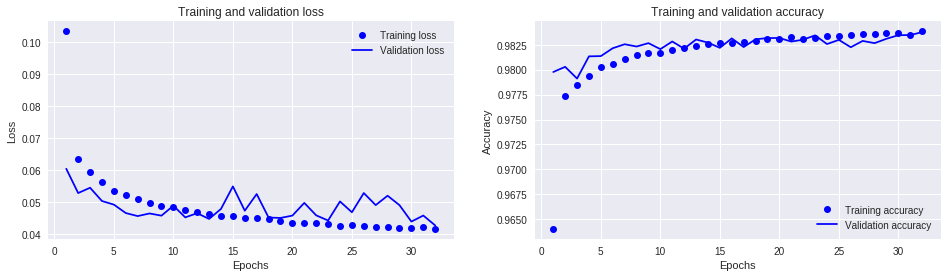

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 62s 2ms/step
([0.04135082676474454, 0.9840879294428915], 0.9880553417199033)
